# Edibility of Mushrooms
## Introduction
Mushrooms are important in our diet, since they are an essential source of nutrition including niacin, riboflavin, selenium, potassium, and vitamin D which are precluding of hypertension, Alzheimer, Parkinson, and high risk of stroke (Jahan Pinky et al., 2019). However, not all species of mushroom are edible. According to Chowdhury and Ojha (2017), humans have identified 45,000 species of mushrooms worldwide, but the number of edible species is only 2000. Plus, identifying the edibility of a mushroom is a task too difficult to be done manually (Jahan Pinky et al., 2019). Automation through machine learning seems to be a feasible solution. Therefore, in our project, we attempt to apply the classification algorithm to predict the edibility of mushroom using data of its physical characteristics and briefly evaluate the performance of our model. 

### The Dataset
"Secondary mushroom data" from UCI Machine Learning Repository (https://mushroom.mathematik.uni-marburg.de/files/) is used to answer the question. This dataset includes 61069 hypothetical mushrooms with caps based on 173 species (353 mushrooms per species). Each mushroom is identified as one of two classes: edible(e) and poisonous(p), and each observation of a mushroom contains 20 variables. Of the 20 variables, 3 are continuous, and 17 are nominal (3 binary, and 14 categorical). 18 of them are physical characteristics of the mushroom, and 2 are of the mushrooms' growing habitat and season.

### Loads data from the original source on the web
We download the data from the internet, assign it to a local variable, and look at a preview.

In [1]:
library(tidyverse)
library(tidymodels)
library(cowplot)
set.seed(777)
link <- "https://mushroom.mathematik.uni-marburg.de/files/SecondaryData/secondary_data_shuffled.csv"
mushrooms <- read_delim(link, delim=";") # download our dataset

# DOWN SAMPLE TO COMPILE IN TIME
mushrooms <- sample_n(mushrooms, 250, replace=FALSE)

head(mushrooms) # show the first 6 examples

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,⋯,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
<chr>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>
p,10.81,x,i,o,FALSE,a,NA,y,11.87,⋯,r,NA,o,NA,NA,TRUE,r,n,d,a
p,10.05,x,y,y,FALSE,a,NA,o,13.28,⋯,r,NA,y,NA,NA,TRUE,r,n,d,w
p,2.64,f,NA,w,FALSE,a,c,n,2.88,⋯,NA,i,w,NA,NA,FALSE,f,NA,p,a
e,16.64,f,y,w,FALSE,NA,NA,w,22.87,⋯,s,NA,n,NA,NA,TRUE,m,NA,d,u
p,3.01,b,NA,k,FALSE,a,NA,n,10.23,⋯,NA,NA,g,NA,w,FALSE,f,k,g,u
p,11.19,x,e,y,TRUE,p,NA,o,8.68,⋯,NA,NA,u,NA,NA,FALSE,f,NA,d,a


Table 1. The first 6 rows of the "Secondary Mushroom Data" dataset

### Wrangles and cleans the data
We change the column names of the dataframe to be "code-friendly", and we split our data into two sets, one for training and one for testing. We then select only the continuous variables (width, height, and diameter) and the label (whether the mushroom is poison or edible.

In [2]:
new_colnames <- map(colnames(mushrooms), function (col_name) gsub("-", "_", col_name)) # replace '-' with '_'
new_colnames[2] <- 'diameter' # compact the names of diameter, height, and width
new_colnames[10] <- 'height'
new_colnames[11] <- 'width'
colnames(mushrooms) <- new_colnames
                    
mushroom_split <- mushrooms |>
    mutate(across(-c(diameter, height, width), factor)) |>
    initial_split(prop=0.75, strata=class)
                    
mushroom_training_raw <- training(mushroom_split)
mushroom_training <- mushroom_training_raw |>
    select(class, diameter, height, width)
head(mushroom_training)
                    
mushroom_testing_raw <- testing(mushroom_split)
mushroom_testing <- mushroom_testing_raw |>
                    select(class, diameter, height, width)

class,diameter,height,width
<fct>,<dbl>,<dbl>,<dbl>
e,16.64,22.87,17.55
e,9.20,6.40,17.46
e,3.27,4.40,10.13
e,7.74,11.98,25.34
e,7.84,4.46,11.94
e,5.78,5.57,4.28


Table 2. The first 6 rows of a cleaned and wrangled "Secondary Mushroom Data" with only diamter, height, and width as variables.

### A summary of the data set
We preview how many mushrooms of each class are in our data, and what the average width, height, and diameter look like between the two classes.

In [3]:
#This table reports the number of observations in each class
summarize_mushroom <- mushroom_training |>
    group_by(class) |>
    summarize(n = n(),
             proportion = n/nrow(mushroom_training))
summarize_mushroom

class,n,proportion
<fct>,<int>,<dbl>
e,86,0.459893
p,101,0.540107


Table 3.1. The number of observations in each class (edible(e)/poisonous(p))

In [4]:
#This table gives the means of the predictor variables in our analysis
means_mushroom <- mushroom_training |>
    select(-class) |>
    map_df(mean)
    means_mushroom

diameter,height,width
<dbl>,<dbl>,<dbl>
6.060695,6.194011,10.77497


Table 3.2. The means of the predictor variables in our analysis

In [5]:
#This calculates the number of rows that have missing data
missing_data <- mushroom_training |>
    filter(is.na(class) || is.na(diameter) || is.na(height) || is.na(width)) |>
    nrow()
missing_data

[1] 0

Therefore, 0 rows in the dataset have missing data.

### Visualization of predictive (continuous) variables 
We plot the relative frequencies of width, height, and diameter between the classes, and make scatter plots of each combination to show what things our model could pick up on.

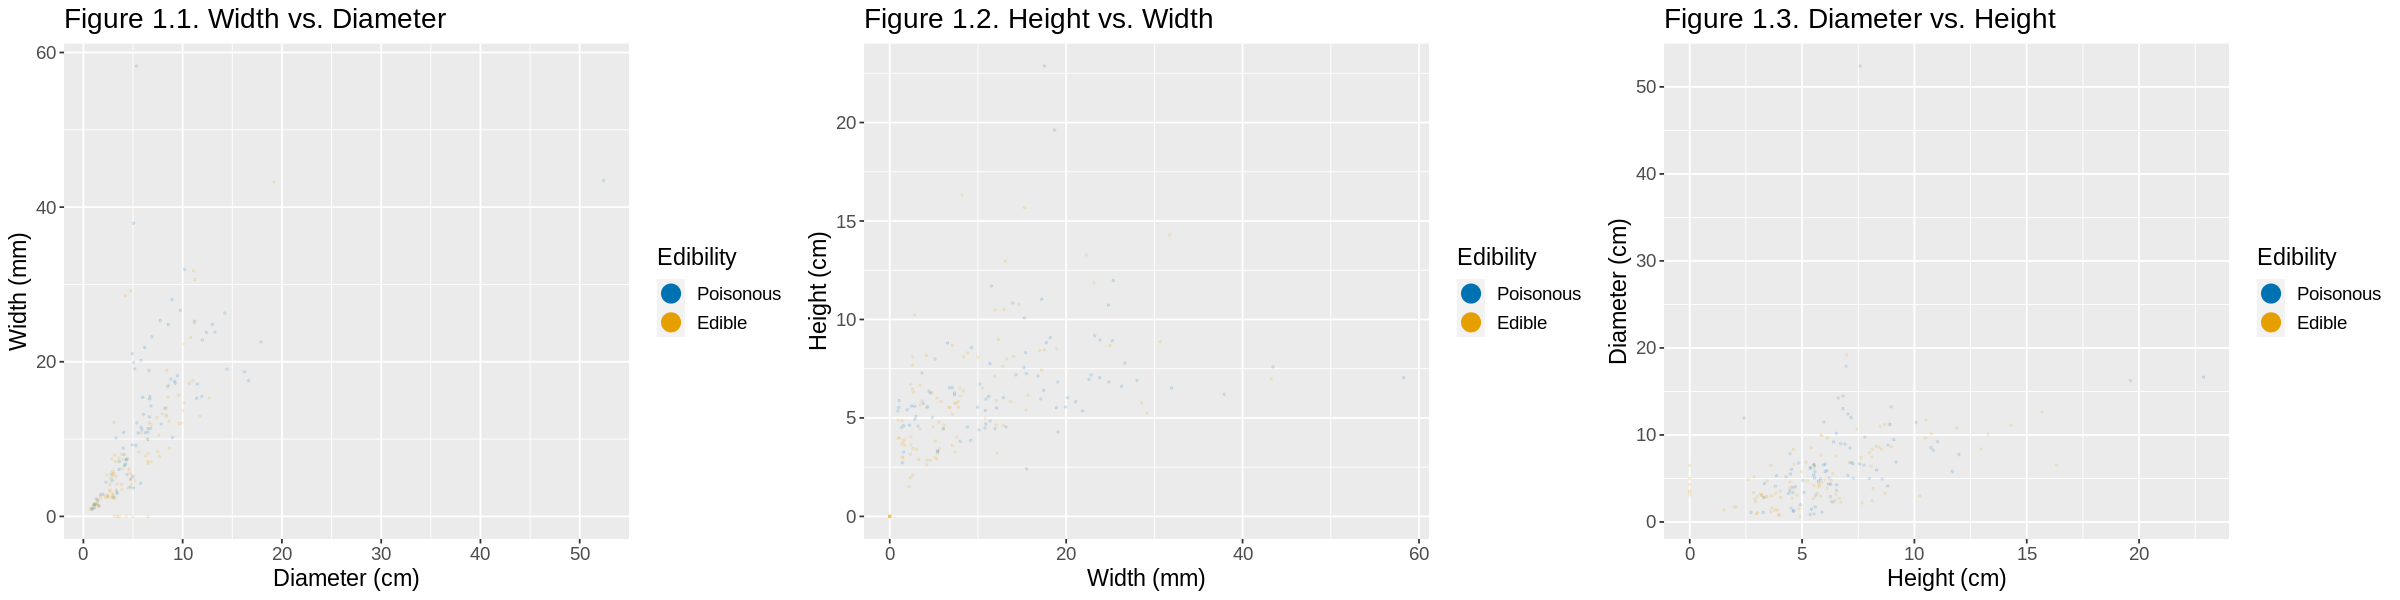

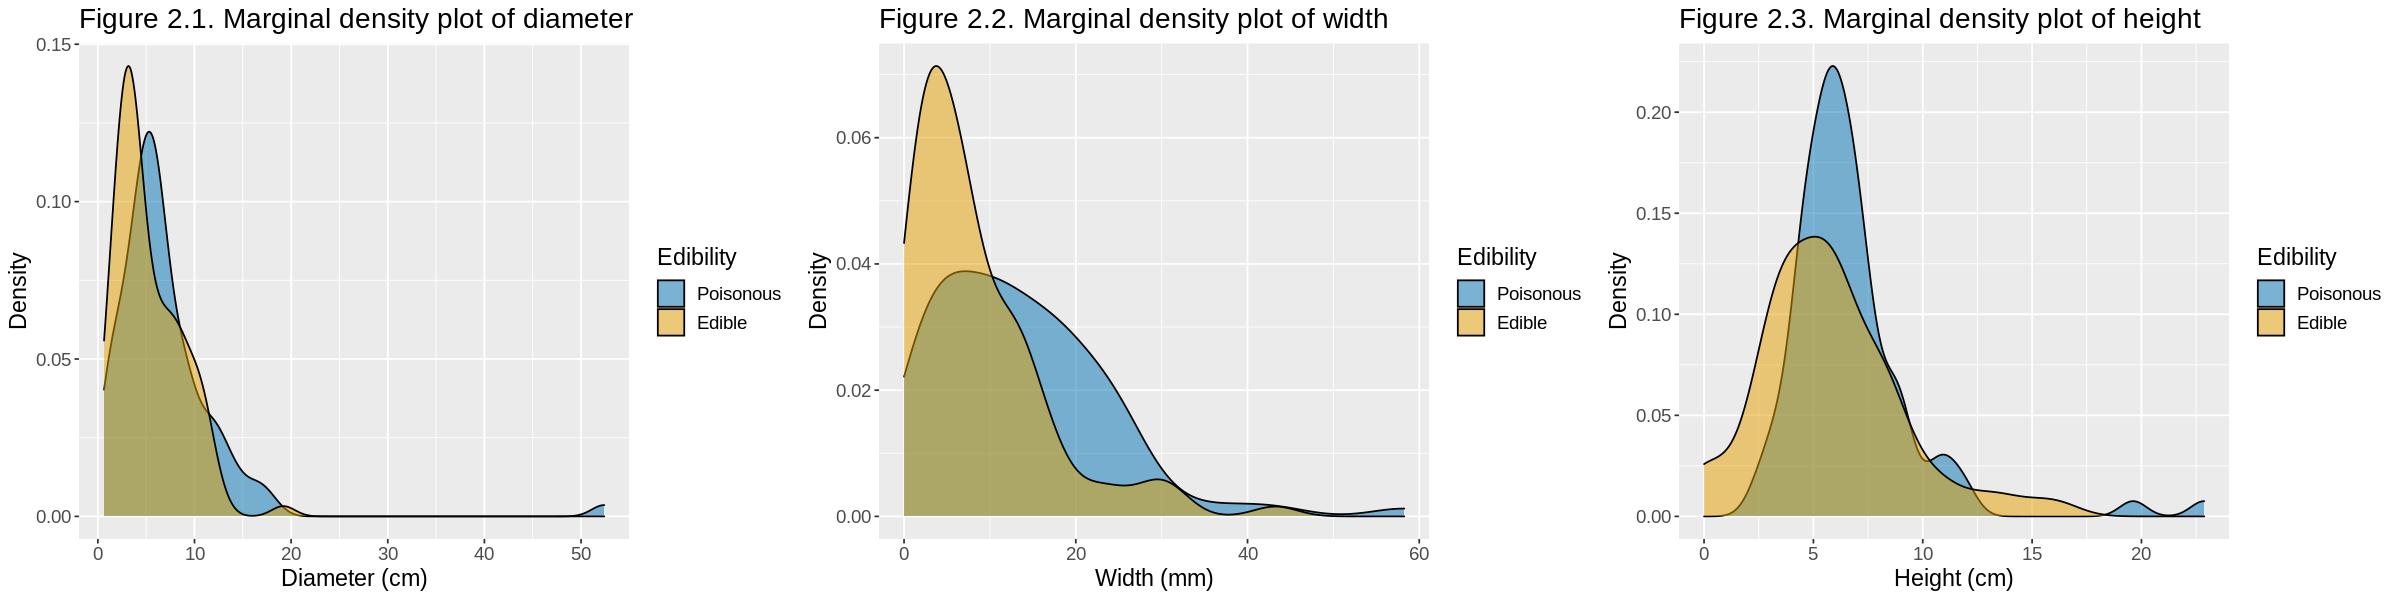

In [6]:
# Width vs. Diameter
mushroom_plot1 <- mushroom_training |>
    ggplot(aes(x=diameter, y=width, color=class)) +
    geom_point(alpha=0.1, size=.4) +
    labs(x="Diameter (cm)", y="Width (mm)", color="Edibility") +
    ggtitle("Figure 1.1. Width vs. Diameter") +
    scale_color_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    theme(text=element_text(size=14)) + 
    guides(color = guide_legend(override.aes = list(alpha=1, size = 5)))

# Height vs. Width
mushroom_plot2 <- mushroom_training |>
    ggplot(aes(x=width, y=height, color=class)) +
    geom_point(alpha=0.1, size=.4) +
    labs(x="Width (mm)", y="Height (cm)", color="Edibility") +
    ggtitle("Figure 1.2. Height vs. Width") +
    scale_color_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    theme(text=element_text(size=14)) + 
    guides(color = guide_legend(override.aes = list(alpha=1, size = 5)))

# Diameter vs. Height
mushroom_plot3 <- mushroom_training |>
    ggplot(aes(x=height, y=diameter, color=class)) +
    geom_point(alpha=0.1, size=.4) +
    labs(x="Height (cm)", y="Diameter (cm)", color="Edibility") +
    scale_color_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    ggtitle("Figure 1.3. Diameter vs. Height") +
    theme(text=element_text(size=14)) + 
    guides(color = guide_legend(override.aes = list(alpha=1, size = 5)))

# Marginal density plot of diameter (top panel)
diameterDensity <- ggplot(mushroom_training, aes(diameter, fill=class)) + 
    geom_density(alpha=.5) + 
    labs(x = "Diameter (cm)", y = "Density", fill = "Edibility") +
    ggtitle("Figure 2.1. Marginal density plot of diameter") +
    scale_fill_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    #theme(legend.position = "none") +
    theme(text=element_text(size=14))
#diameterDensity

# Marginal density plot of width (right panel)
widthDensity <- ggplot(mushroom_training, aes(width, fill=class)) + 
    geom_density(alpha=.5) + 
    labs(x = "Width (mm)", y = "Density", fill = "Edibility") +
    ggtitle("Figure 2.2. Marginal density plot of width") +
    scale_fill_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    #theme(legend.position = "none") +
    theme(text=element_text(size=14))
#widthDensity

# Marginal density plot of height
heightDensity <- ggplot(mushroom_training, aes(height, fill=class)) + 
    geom_density(alpha=.5) + 
    labs(x = "Height (cm)", y = "Density", fill = "Edibility") +
    ggtitle("Figure 2.3. Marginal density plot of height") +
    scale_fill_manual(labels = c("Poisonous", "Edible"), values = c("#0072B2", "#E69F00")) +
    #theme(legend.position = "none") +
    theme(text=element_text(size=14))
#heightDensity

options(repr.plot.width = 20, repr.plot.height = 5)
plot_grid(mushroom_plot1, mushroom_plot2, mushroom_plot3, ncol = 3)
plot_grid(diameterDensity, widthDensity, heightDensity, ncol = 3)

Figure 1.1, 1.2, and 1.3 shows the sets of relationship between 2 of the predictive variables in terms of the mushroom's edibility. We can see that the majority dimensions of poisonous and edible mushrooms follow similar trends. However, there are also many large outlier clusters that entirely consist of one class. This is also shown in the spread of the marginal density plots (Figure 2.1, 2.2, 2.3). For example, in the marginal density plot regarding the width variable (Figure 2.2), the density distribution for poisinous mushroom has a larger mean and variance, indicating that a greater proportion of poisonous mushrooms has greater stem width than that of the edible ones.

## Analyzing and Selecting Predictor Variables
- To select our predictor variables, we will tune the models and create distinct recipees for each set of predictor variables, and then compare the accuracy of the models.
- We will set `neighbours` to `tune()` in our K-nn recipe in combination with a 5-fold cross validation so that each model that we compare will be at its optimal accuracy.
    - Note that `k` values sued for the cross-validation will be values from 
    1 to 50.
        - For now, it does not completely matter if the accuracy is                   maximized
          (if we have the best `k` value), as we're analyzing how a                   predictor variable affects the model.
- The data must also be scaled and centered, as the ranges of variables are different.

In [7]:
mushroom_vfold <- vfold_cv(mushroom_training, v=5, strata=class)

gridvals<-tibble(neighbors = seq(from=10,to=50,by=10)) # FOR DOWNSAMPLE ONLY
# gridvals<-tibble(neighbors = seq(from=1,to=50,by=1))

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

In [8]:
mushroom_recipe<-recipe(class ~ width, mushroom_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

mushroom_results <- workflow() |>
    add_recipe(mushroom_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = mushroom_vfold, grid=gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
mushroom_results_best <- mushroom_results |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(mean)

In [9]:
mushroom_recipe2<-recipe(class ~ width + height, mushroom_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

mushroom_results2 <- workflow() |>
    add_recipe(mushroom_recipe2) |>
    add_model(knn_spec) |>
    tune_grid(resamples = mushroom_vfold, grid=gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
mushroom_results_best2 <- mushroom_results2 |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(mean)

In [10]:
mushroom_recipe3<-recipe(class ~ width + height + diameter, mushroom_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

mushroom_results3 <- workflow() |>
    add_recipe(mushroom_recipe3) |>
    add_model(knn_spec) |>
    tune_grid(resamples = mushroom_vfold, grid=gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
mushroom_results_best3 <- mushroom_results3 |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(mean)

In [11]:
model<-c("class ~ width", "class ~ width + height", "class ~ width + height + diameter")
accuracies <- c(mushroom_results_best, mushroom_results_best2, mushroom_results_best3)
acc_table<-tibble('Recipe Input'=character(), Accuracy = numeric()) |>
add_row('Recipe Input' = model, Accuracy = accuracies)
         
print("Table: Resulting Accuracies of Different Predictor Variables")
acc_table

[1] "Table: Resulting Accuracies of Different Predictor Variables"


Recipe Input,Accuracy
<chr>,<dbl>
class ~ width,0.6832987
class ~ width + height,0.6408870
class ~ width + height + diameter,0.6263340


## Finding the Optimal `k` value and Building the Final Model
- First, we will build new components that need to be updated for our final model.
    - mainly, we need a new set of `k` values to test and a new workflow.
- We will then tune our model with various `k` values, and pick the best one through a visualization.

In [12]:
k_vals<-tibble(neighbors = seq(from =1, to=100, by=1))

# mushroom_vfold, mushroom_recipe, and knn_spec are previously defined
mushroom_results<-workflow() |>
    add_recipe(mushroom_recipe3) |>
    add_model(knn_spec) |>
    tune_grid(resamples = mushroom_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

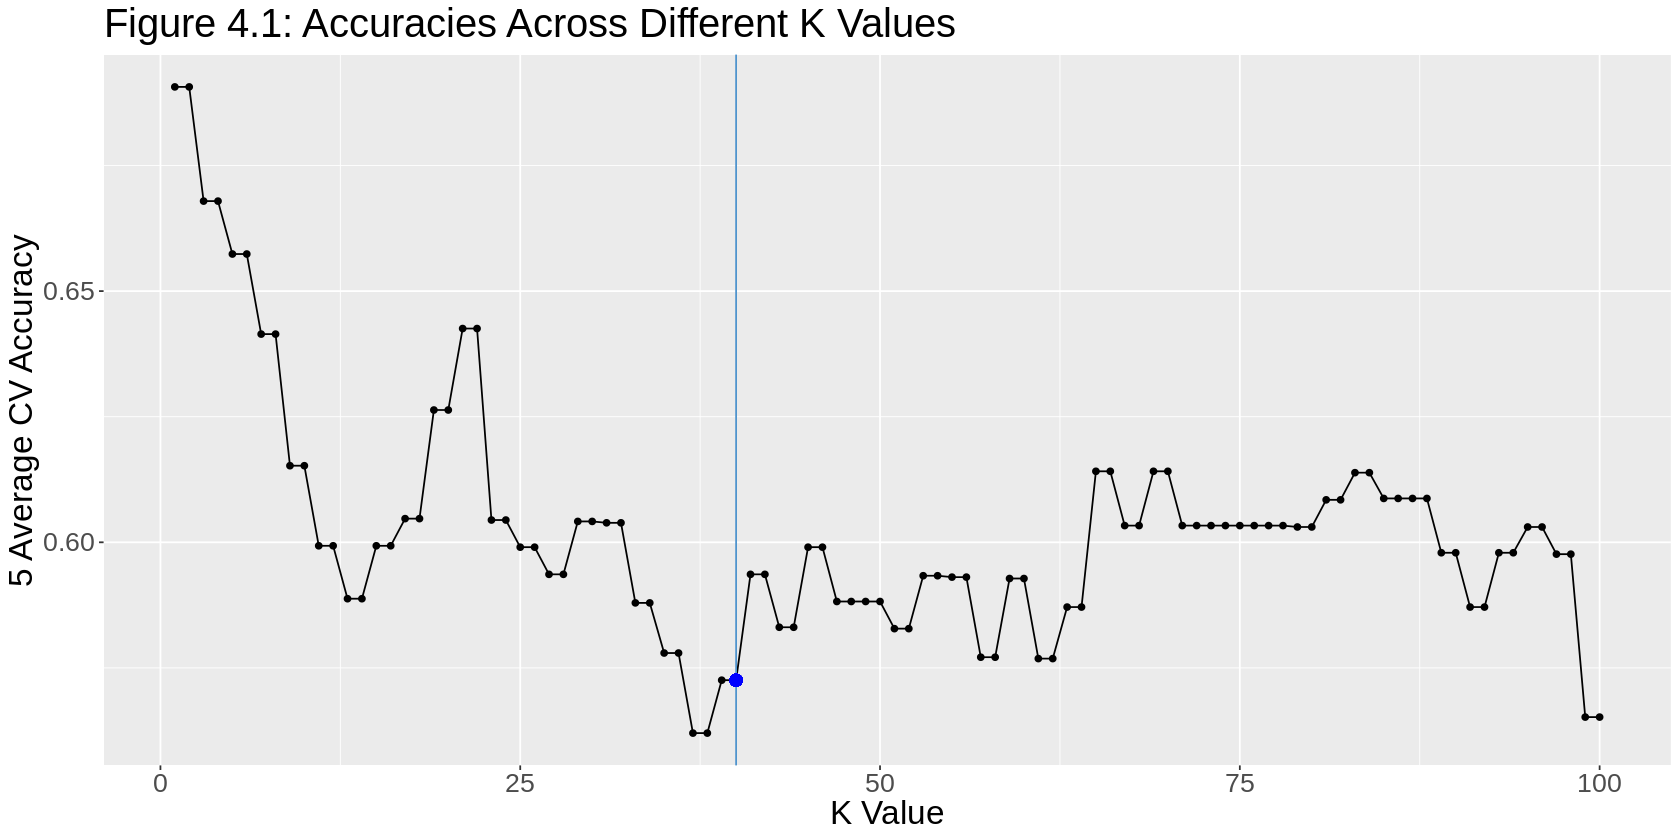

In [13]:
options(repr.plot.width = 14, repr.plot.height = 7)

best_k_y <- mushroom_results |>
    filter(neighbors == 40) |>
    pull(mean)

k_accuracies_plot <- mushroom_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 40, colour = "steelblue3") +
    geom_point(aes(x = 40, y = best_k_y), size = 3, colour = "blue") +
    labs(x = "K Value", y = "5 Average CV Accuracy") +
    ggtitle("Figure 4.1: Accuracies Across Different K Values") +
    theme(text = element_text(size = 20))

k_accuracies_plot

- We can see from the above figure that at `k=40`, there is a 3-point maximum plateau.
    - This shows that there is a consistency in the maximum value, which increases the validity of this value. The accuracy doesn't improve as `k>60` too much. Hence, valuing computational power.

*Knowing this*, we will choose a value of `k=40` for our model.

## Building the Final Model
* We will create a new model specification and a new workflow with our selected `k` value.

In [14]:
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 40) |>
  set_engine("kknn") |>
  set_mode("classification")

# ato_recipe is previously defined
mushroom_fit <- workflow() |>
    add_recipe(mushroom_recipe3) |>
    add_model(best_knn_spec) |>
    fit(data = mushroom_training)

print("Figure 5.2: Final Classification Model")
mushroom_fit

[1] "Figure 5.2: Final Classification Model"


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(40,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3850267
Best kernel: rectangular
Best k: 40

## 6 Evaluation of Model and Conclusion
* Now, we will evaluate the model that we have created by fitting our testing set (`mushroom_testing`) with `mushroom_fit`.

In [15]:
mushroom_predictions_final <- predict(mushroom_fit, mushroom_testing) |>
    bind_cols(mushroom_testing)

mushroom_acc <- mushroom_predictions_final |>
    metrics(truth = class, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1)

print("Table 6.1: Model Accuracy on the Testing Set")
mushroom_acc

[1] "Table 6.1: Model Accuracy on the Testing Set"


.metric,.estimate
<chr>,<dbl>
accuracy,0.6825397


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



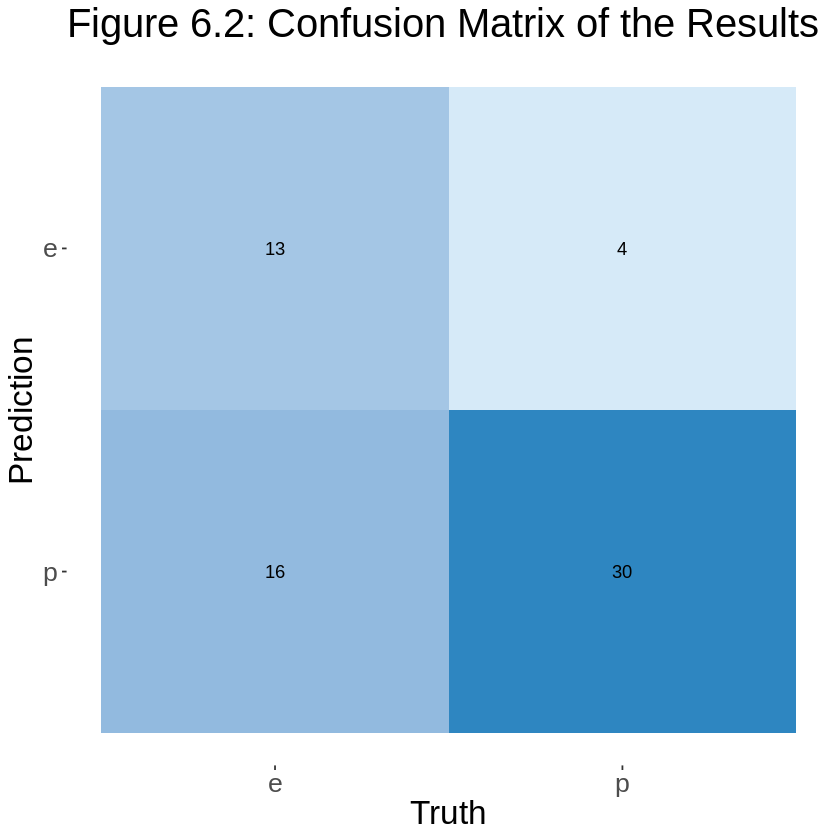

In [16]:
options(repr.plot.width = 7, repr.plot.height = 7)

mushroom_matrix <- mushroom_predictions_final |>
    conf_mat(truth = class, estimate = .pred_class)
mushroom_matrix <- autoplot(mushroom_matrix, type = "heatmap") +
    scale_fill_gradient(low="#D6EAF8",high = "#2E86C1") +
    labs(title = "Figure 6.2: Confusion Matrix of the Results") +
    theme(text = element_text(size = 20))

mushroom_matrix

- From Figure 6.2, we can see that the model has an accuracy of 80% when classifying the observations of the testing set.
- We can also see from the matrix that most of the correctly predicted values are when the model predicts a poisonous mushroom.
    - This slight variation might be due to high number of poisonous mushrooms in the dataset.
- We get a recall score of 0.771483225 and a precision score of 0.775477 with an f-score of 0.773474955.

In [17]:
mean_per_var <- mushroom_training |>
    group_by(class) |>
    summarize(mean_height=mean(height), mean_width=mean(width), mean_diameter=mean(diameter))
print("Table 6.3: Mean of Variables across Mushroom Class")
mean_per_var

[1] "Table 6.3: Mean of Variables across Mushroom Class"


class,mean_height,mean_width,mean_diameter
<fct>,<dbl>,<dbl>,<dbl>
e,6.705581,13.602209,6.987907
p,5.758416,8.367624,5.271188


Looking at the table above, we can surmise that the model could distinguish between the two classes due to the certain gap between the means of the variables of the two classes.

# Discussion

#### - Finding:
We expected our model to do better than the majority classifier - just picking the most common label, and our model achieved this. From the summary of our dataset, the most common label is poison mushrooms (proportion of poison mushrooms = 0.55 versus proportion of edible mushrooms = 0.45). If we assign every mushroom the label of "poison," then the accuracy would be around 55%. Our model improved the prediction quite a bit on the majority classifier, given that the accuracy raises to roughly 80%. 

#### - Impact:

There is currently no common methodologies other than relying on a mushroom expert to distinguish between poisonous and edible mushrooms (citation: https://www.betterhealth.vic.gov.au/health/healthyliving/fungi-poisoning). Our model could provide the public a tool for identifying the edibility of varieties and assist experts in making judgments. 

#### - Future Questions and possible improvements:
Our model has an accuracy of 80% in prediction. Though it seems to perform a good job, by looking at the confusion matrix, we see that approximately 8.5% (1309 out of 15268) of poisonous mushrooms are predicted as edible. This may cause a serious problem in practice, when people trust the prediction result by our classifier and eat the poison mushrooms! Future data scientists may try different machine learning algorithms to improve the accuracy of the model.

Furthermore, our model could be difficult both to collect data for and to use because of the large number of features. Future data scientists might adjust our model to take images as input to make these easier. 

Additionally, an improved model might use regression to predict a numerical value for a mushroom's toxicity to better represent its non-binary effects.

# References
- Jahan Pinky, N., Mohidul Islam, S. M., &amp; Sharmin Alice, R. (2019). Edibility detection of mushroom using ensemble methods. International Journal of Image, Graphics and Signal Processing, 11(4), 55–62. https://doi.org/10.5815/ijigsp.2019.04.05 
- D. R. Chowdhury, S. Ojha. (2017). An Empirical Study on Mushroom Disease Diagnosis: A Data Mining Approach. International Research Journal of Engineering and Technology, 4(1), 529-534.

Data set:
- UCI Machine Learning Repository. (1987). Mushroom data set. 
https://archive.ics.uci.edu/ml/datasets/mushroom 